In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import root_mean_squared_error
from reservoirpy.datasets import mackey_glass
import pandas as pd
#import pickle
from datetime import datetime
import seaborn as sns

In [2]:
import wfdb
from wfdb import processing

# Download a sample record from the MIT-BIH Arrhythmia Database
record_name = '100'
#wfdb.dl_database('mitdb', './mitdb')

# Read the ECG signal and annotation from the dataset
record = wfdb.rdrecord(f'./mitdb/{record_name}')
annotation = wfdb.rdann(f'./mitdb/{record_name}', 'atr')

# Extracting the signal (ECG data)
ecg_signal = record.p_signal

# Display some information
print(f"Signal shape: {ecg_signal.shape}")
print(f"Signal sampling rate: {record.fs} Hz")

Signal shape: (650000, 2)
Signal sampling rate: 360 Hz


In [3]:
ecg_dataset=[]
for i in range(100,235):
    record_name = str(i)
    #wfdb.dl_database('mitdb', './mitdb')

    try:
        # Read the ECG signal and annotation from the dataset
        record = wfdb.rdrecord(f'./mitdb/{record_name}')
        annotation = wfdb.rdann(f'./mitdb/{record_name}', 'atr')

        # Extracting the signal (ECG data)
        ecg_signal = record.p_signal

        # Display some information
        ecg_dataset.append(ecg_signal[:, 0])
        ecg_dataset.append(ecg_signal[:, 1])
    except:
        ...

In [37]:
class EchoStateNetwork:
    def __init__(self, n_input, n_reservoir, n_output, spectral_radius=1.25, sparsity=0.1, alpha = 1, noise=0.001, random_state=None):
        """
        Initialize the Echo State Network.
        
        Parameters:
        - n_input: Number of input units.
        - n_reservoir: Number of reservoir neurons.
        - n_output: Number of output units.
        - spectral_radius: Scaling factor for the reservoir weights.
        - sparsity: Fraction of weights set to zero in the reservoir.
        - noise: Amount of noise to add to the reservoir dynamics.
        - random_state: Random seed for reproducibility.
        """
        # just for the random seed
        if random_state is not None:
            np.random.seed(random_state)
        
        self.n_input = n_input
        self.n_reservoir = n_reservoir
        self.n_output = n_output
        self.spectral_radius = spectral_radius
        # this number is used for making the sparsity
        self.sparsity = sparsity
        self.alpha = alpha
        
        # pbbly for the noise ammount
        self.noise = noise

        # Input weight matrix
        self.W_in = np.random.uniform(-1, 1, (n_reservoir, n_input + 1))  # +1 for bias term

        # Reservoir weight matrix (random sparse matrix)
        W_res = np.random.rand(n_reservoir, n_reservoir) - 0.5
        # ah ok so you 0 out every place that has more thant sparsity based on a normaly distributed matrix
        W_res[np.random.rand(*W_res.shape) > sparsity] = 0
        # Rescale to ensure the spectral radius
        rho_W = np.max(np.abs(np.linalg.eigvals(W_res)))
        self.W_res = W_res * (spectral_radius / rho_W)
        
        

        # Output weight matrix (initialized later)
        self.W_out = None
        
    def get_reservoir(self):
        return self.W_res
    
    def get_w_in(self):
        return self.W_in
    
    def set_reservoir(self, res):
        self.W_res = res
    
    def set_w_in(self,w_in):
        self.W_in = w_in

    def _update_reservoir(self, x, r):
        """
        Update the reservoir state.
        
        Parameters:
        - x: Current input.
        - r: Previous reservoir state.
        
        Returns:
        - Updated reservoir state.
        """
        input_with_bias = np.hstack([1.0, x])  # Add bias term to input
        # input_wiht_bias.shape == 1,self.n_input+1 
        # W_in.shape == self.n_reservoir, self.n_input+1
        # np.dot(self.W_in, input_with_bias).shape == self.n_reservoir
        # r_new.shape == self.n_reservoir
        r_new = np.tanh(np.dot(self.W_in, input_with_bias) + np.dot(self.W_res, r))# + self.noise * np.random.randn(self.n_reservoir))

        r_new = ( 1 - self.alpha ) * r + self.alpha * r_new
        return r_new
    
    def _update_reservoir2(self, x, r):
        """
        Update the reservoir state.
        
        Parameters:
        - x: Current input.
        - r: Previous reservoir state.
        
        Returns:
        - Updated reservoir state.
        """
        input_with_bias = np.hstack([1.0, x])  # Add bias term to input
        # input_wiht_bias.shape == 1,self.n_input+1 
        # W_in.shape == self.n_reservoir, self.n_input+1
        # np.dot(self.W_in, input_with_bias).shape == self.n_reservoir
        # r_new.shape == self.n_reservoir
        r_new = np.tanh(np.dot(self.W_in, input_with_bias) + np.dot(self.W_res, r))# + self.noise * np.random.randn(self.n_reservoir))

        #r_new = ( 1 - self.alpha ) * r + self.alpha * r_new
        return r_new

    def fit(self, X, y, ridge_reg=1e-6):
        """
        Train the output weights using ridge regression.
        
        Parameters:
        - X: Input data (n_samples, n_timesteps, n_features).
        - y: Target data (n_samples, n_timesteps, n_output).
        - ridge_reg: Regularization strength for ridge regression.
        """
        n_samples, n_timesteps, _ = X.shape
        
        # Initialize reservoir states
        reservoir_states = np.zeros((n_samples * n_timesteps, self.n_reservoir))

        # Collect reservoir states
        for i in range(n_samples):
            r = np.zeros(self.n_reservoir)  # Initial reservoir state
            for t in range(n_timesteps):
                r = self._update_reservoir(X[i, t], r)
                reservoir_states[i * n_timesteps + t] = r

        # Add bias term to reservoir states
        reservoir_states_with_bias = np.hstack([np.ones((reservoir_states.shape[0], 1)), reservoir_states])

        # Flatten target data
        target = y.reshape(-1, self.n_output)

        # Ridge regression to compute output weights
        self.W_out = np.dot(
            np.linalg.pinv(np.dot(reservoir_states_with_bias.T, reservoir_states_with_bias) + ridge_reg * np.eye(reservoir_states_with_bias.shape[1])),
            np.dot(reservoir_states_with_bias.T, target)
        )

    def predict(self, X):
        """
        Predict output for the given input data.
        
        Parameters:
        - X: Input data (n_samples, n_timesteps, n_features).
        
        Returns:
        - Predicted output (n_samples, n_timesteps, n_output).
        """
        n_samples, n_timesteps, _ = X.shape
        predictions = np.zeros((n_samples, n_timesteps, self.n_output))

        for i in range(n_samples):
            r = np.zeros(self.n_reservoir)  # Initial reservoir state
            for t in range(n_timesteps):
                r = self._update_reservoir(X[i, t], r)
                input_with_bias = np.hstack([1.0, r])  # Add bias term
                predictions[i, t] = np.dot(input_with_bias, self.W_out)

        return predictions
    
    #def get_activations(self, X):
    #    n_samples, n_timesteps, _ = X.shape
    #    activations = np.zeros((n_samples, n_timesteps, self.n_reservoir+self.n_input+1))
#
    #    for i in range(n_samples):
    #        r = np.zeros(self.n_reservoir)  # Initial reservoir state
    #        for t in range(n_timesteps):
    #            
    #            r = self._update_reservoir2(X[i, t], r)
    #            inputs = np.hstack([1,X[i,t]]) 
    #            # I wan't to store these values
    #            activations[i,t] = np.concatenate([inputs, r])
#
#
    #    return activations
    
    def get_activations(self, X):
        n_samples, n_timesteps, _ = X.shape
        
        activations = np.zeros((n_samples, n_timesteps, self.n_reservoir+self.n_input+1))
        
        for i in range(n_samples):
            r = np.zeros(self.n_reservoir)  # Initial reservoir state
            for t in range(n_timesteps):

                r = self._update_reservoir2(X[i,t], r)
                inputs = np.hstack([1,X[i,t]]) 
                # I wan't to store these values
                activations[i, t] = np.concatenate([inputs, r])

        return activations

# Example usage:

# Initialize ESN
esn = EchoStateNetwork(n_input=1, n_reservoir=100, n_output=1, spectral_radius=1.25, sparsity=0.1, random_state=42)

# Create dummy training data (sine wave)
timesteps = 200
X_train = np.sin(np.linspace(0, 10, timesteps)).reshape(1, timesteps, 1)
y_train = np.cos(np.linspace(0, 10, timesteps)).reshape(1, timesteps, 1)

# Train the ESN
esn.fit(X_train, y_train)

# Predict on the training data
y_pred = esn.predict(X_train)

# Output the first few predictions


In [22]:
def get_signal(signal, offset, shift, window_size, max_val):
    # offset: starting position
    # shift: number of steps to shift the signal
    if window_size+shift < max_val:
        return signal[offset+shift: offset+window_size+shift].reshape(1,-1,1)
    
    return None

In [23]:
def get_gt(signal,offset,shift,window_size):
    X_train = get_signal(signal, offset, shift, window_size, len(signal))
    Y_train = get_signal(signal, offset, 0, window_size, len(signal))
    return X_train, Y_train

In [24]:
def create_ecg_dataset(ecg_dataset,shift,window_size,offset=0):
    X_data = []
    Y_data = []
    for ecg in ecg_dataset:
        x_data, y_data = get_gt(ecg,offset,shift,window_size)
        X_data.append(x_data)
        Y_data.append(y_data)
        
    X_data = np.vstack(X_data).reshape(len(ecg_dataset),-1,1)
    Y_data = np.vstack(Y_data).reshape(len(ecg_dataset),-1,1)
    
    train_index = np.load('train_index.npy')
    val_index = np.load('val_index.npy')
    test_index = np.load('test_index.npy')
    
    X_train = X_data[train_index]
    Y_train = Y_data[train_index]
    
    X_val = X_data[val_index]
    Y_val = Y_data[val_index]
    
    X_test = X_data[test_index]
    Y_test = Y_data[test_index]
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [25]:
shift = 12
window_size = 2000
X_train, Y_train, X_val, Y_val, X_test, Y_test = create_ecg_dataset(ecg_dataset,shift, window_size)

In [26]:
from glob import glob
import pickle
import os.path as osp

In [27]:
def load_all(root_dir):
    paths = glob(osp.join(root_dir,'*'))
    return paths


In [28]:
paths = load_all('reservoir_data/res_16/')
paths[0]

'reservoir_data/res_16/13-07_47_33.pickle'

In [29]:
def load_single(file_path, display=False):
    with open(file_path, 'rb') as file:
        # Serialize and write the variable to the file
        data = pickle.load(file)
        
    rmse = data['mean_rmse']
    
    percentile = 2
    percentile_value = np.percentile(rmse,percentile)
    
    mask = data['mean_rmse'] < percentile_value
    
    if display:
        sns.histplot(rmse, bins=30, kde=True )
        plt.axvline(percentile_value,color='orange')

        plt.show()
    
    return np.array(data['reservoir'])[mask], np.array(data['w_in'])[mask]


In [30]:
reservoirs, w_ins = load_single(paths[0])

In [14]:
n_res_samples = 1000
n_reservoir = 16
alpha = 0.35
sparsity_a = 0.07
sparsity_b = 0.2
sr_a = 0.7
sr_b = 1.5

In [31]:
reser = reservoirs[0] 
win = w_ins[0]

In [39]:
esn = EchoStateNetwork(n_input=1, n_reservoir=n_reservoir, n_output=1, spectral_radius=1, alpha = alpha, sparsity=0.1)
esn.set_reservoir(reser)
esn.set_w_in(win)
result = esn.get_activations(X_val)

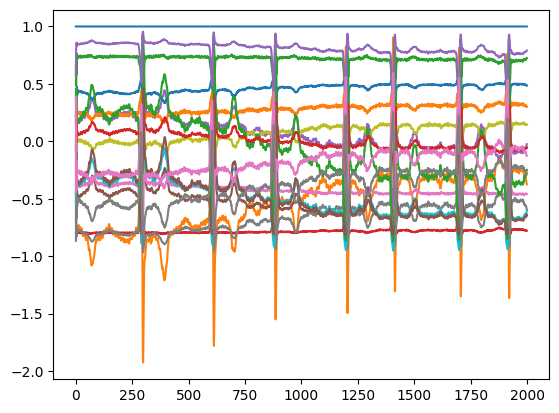

In [40]:
plt.plot(result[0])
plt.show()

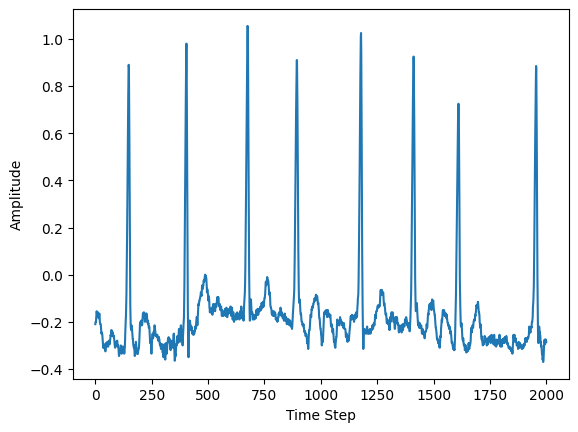

In [43]:
plt.plot(X_val[1])
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.savefig('images/Reservoir_Dataset/reference_ecg.png')
plt.savefig('images/Reservoir_Dataset/reference_ecg.svg')
plt.savefig('images/Reservoir_Dataset/reference_ecg.pdf')

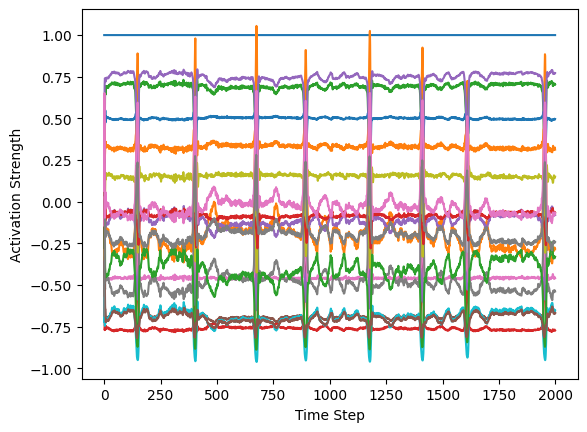

In [44]:
plt.plot(result[1])
plt.xlabel('Time Step')
plt.ylabel('Activation Strength')
plt.savefig('images/Reservoir_Dataset/activations_res16_on_reference_ecg.png')
plt.savefig('images/Reservoir_Dataset/activations_res16_on_reference_ecg.svg')
plt.savefig('images/Reservoir_Dataset/activations_res16_on_reference_ecg.pdf')

Text(0, 0.5, 'Activation Strength')

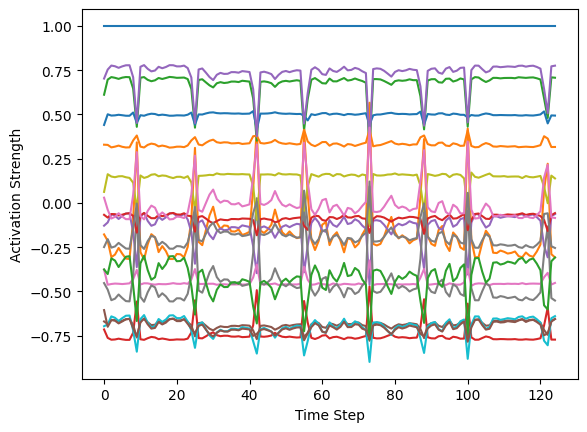

In [61]:
plt.plot(result[1].reshape(125,16,18).mean(axis=1))
plt.xlabel('Time Step')
plt.ylabel('Activation Strength')
plt.savefig('images/Reservoir_Dataset/feature_vectors_res16_on_reference_ecg.png')
plt.savefig('images/Reservoir_Dataset/feature_vectors_res16_on_reference_ecg.svg')
plt.savefig('images/Reservoir_Dataset/feature_vectors_res16_on_reference_ecg.pdf')

In [45]:
esn = EchoStateNetwork(n_input=1, n_reservoir=n_reservoir, n_output=1, spectral_radius=1, alpha = alpha, sparsity=0.1)
esn.set_reservoir(reser)
esn.set_w_in(win)
another_result = esn.get_activations(X_val[1].reshape(1,-1,1))

In [46]:
arr = another_result.reshape(125,16,18)
arr.mean(axis=1).shape

(125, 18)

In [50]:
def get_feature_vectors(X, esn, reservoir, w_in):
    esn.set_reservoir(reservoir)
    esn.set_w_in(w_in)
    result = esn.get_activations(X)
    arr = result.reshape(125,16,18)
    return arr.mean(axis=1).T

In [51]:
esn = EchoStateNetwork(n_input=1, n_reservoir=n_reservoir, n_output=1, spectral_radius=1, alpha = alpha, sparsity=0.1)
X = X_val[1].reshape(1,-1,1)
reser = reservoirs[0] 
win = w_ins[0]

final = get_feature_vectors(X, esn, reser, win)

In [54]:
esn = EchoStateNetwork(n_input=1, n_reservoir=n_reservoir, n_output=1, spectral_radius=1, alpha = alpha, sparsity=0.1)
X = X_val[1]
reser = reservoirs[0] 
win = w_ins[0]

testing = get_feature_vectors(X.reshape(1,-1,1), esn, reser, win)

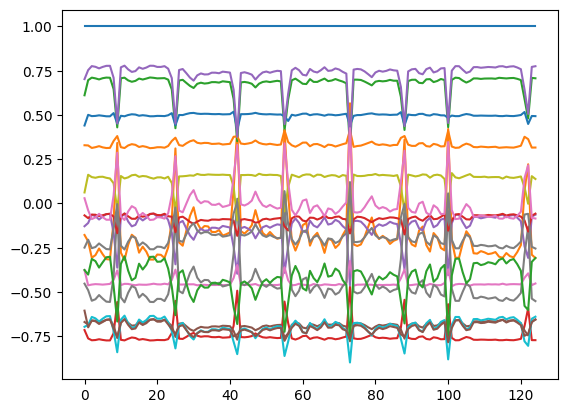

In [57]:
plt.plot(final.T)